# 🏠 부동산 실거래가 예측 대회 - KKH - MODEL
> - 학습, 예측, 평가를 진행한다.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [156]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoost
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

# Optuna
from optuna import create_study
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
import optuna

import eli5
from eli5.sklearn import PermutationImportance

# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [157]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # 서울시 가계대출규모
kb = pd.read_csv('data/jaemyung_kb.csv', encoding='utf-8')

In [158]:
train = pd.merge(train, kb, left_on='계약년월', right_on='date', how='left')
train = train.drop(columns=['date'])

test = pd.merge(test, kb, left_on='계약년월', right_on='date', how='left')
test = test.drop(columns=['date'])

In [159]:
train.sample(3)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수
227091,서울특별시 광진구 화양동,111-89,111.0,89.0,위너스힐,58.05,202202,24,10,2021,광나루로20길 34,NaN,,직거래,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000,광진구,화양동,127.073978,37.545606,화양동 위너스힐,어린이대공원(세종대),7호선,274.368740,1,1,55.5
1113261,서울특별시 영등포구 양평동3가,55-1,55.0,1.0,경남아너스빌,84.92,200704,3,15,1998,선유로33길 22,NaN,,-,-,NaN,0226789965,0226789967,NaN,분양,위탁관리,혼합식,개별난방,1.0,179.0,경남기업 주식회사,경남기업 주식회사,1998-07-18 00:00:00.0,21487.0,12499.0,16739.0,108.0,71.0,0.0,NaN,NaN,NaN,2024-07-10 22:54:50.0,107-82-60891-0,직영,NaN,직영,0.0,187.0,의무,2013-06-23 12:04:19.0,Y,N,2013-03-07 09:46:28.0,33200,영등포구,양평동3가,126.888350,37.527227,양평동3가 경남아너스빌,양평,5호선,268.963312,1,0,NaN
59121,서울특별시 서초구 서초동,1333,1333.0,0.0,신동아,88.68,201801,12,11,1978,사임당로 137,NaN,,-,-,아파트,0234728700,234731372.0,NaN,분양,자치관리,혼합식,지역난방,7.0,997.0,신동아건설,신동아건설,1978-12-15 00:00:00.0,113858.0,101866.0,110827.0,0.0,260.0,601.0,NaN,cafe.naver.com/ssdaapt,NaN,2023-09-23 16:41:23.0,21482608450,직영,종합계약,위탁,0.0,1200.0,의무,2019-09-09 16:41:31.0,Y,N,2013-03-07 09:46:18.0,127000,서초구,서초동,127.023917,37.492152,서초동 신동아,강남,신분당선,638.604694,0,1,118.0


In [160]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [161]:
# '계약년월'과 '년월'이 일치하는 경우 '서울시_가계대출' 정보를 train에 병합
train = train.merge(loan, how='left', left_on='계약년월', right_on='년월')
# '년월' 열은 필요 없으므로 삭제
train.drop(columns=['년월'], inplace=True)

test = test.merge(loan, how='left', left_on='계약년월', right_on='년월')
test.drop(columns=['년월'], inplace=True)

In [162]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [163]:
train['국민평수'] = train['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)
test['국민평수'] = test['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)

In [164]:
train = train[train['계약년월'] >= 201301]

In [165]:
# selected_feature_list = ['아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수', 'kb부동산지수']
train = train[selected_feature_list]

In [166]:
train.to_csv('data/kkh_train_final.csv', index=False)

In [167]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # 수치형 피처의 결측치를 -999으로 대체
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,도로명,세대별주차대수,좌표X,좌표Y,target,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수
0,개포6차우성,79.97,282438.7,3,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,124000,0,1,구룡,분당선,1187.672025,0,0,88.4
1,개포6차우성,79.97,282438.7,4,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,123500,0,1,구룡,분당선,1187.672025,0,0,88.4
2,개포6차우성,54.98,282438.7,5,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,91500,0,1,구룡,분당선,1187.672025,0,0,88.4
3,개포6차우성,79.97,283669.8,4,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,130000,0,1,구룡,분당선,1187.672025,0,0,118.0
4,개포6차우성,79.97,283669.8,2,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,117000,0,1,구룡,분당선,1187.672025,0,0,118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034100,종로센트레빌,59.92,201617.4,3,2008,종로구,숭인동,동망산길 47,1.230769,127.015931,37.580983,37800,0,1,창신,6호선,159.102668,1,2,25.1
1034101,종로센트레빌,59.92,201617.4,6,2008,종로구,숭인동,동망산길 47,1.230769,127.015931,37.580983,36800,0,1,창신,6호선,159.102668,1,2,25.1
1034103,묵정,52.46,200072.2,8,1981,중구,묵정동,서애로1길 34,0.368852,127.000034,37.560695,23000,0,1,동대입구,3호선,523.705597,0,4,10.8
1034104,묵정,52.46,199239.5,6,1981,중구,묵정동,서애로1길 34,0.368852,127.000034,37.560695,22500,0,1,동대입구,3호선,523.705597,0,4,18.6


In [168]:
print((train.isnull().mean() * 100).to_string())

아파트명               0.0
전용면적(㎡)            0.0
서울시_가계대출           0.0
층                  0.0
건축년도               0.0
구                  0.0
동                  0.0
도로명                0.0
세대별주차대수            0.0
좌표X                0.0
좌표Y                0.0
target             0.0
top_apt            0.0
국민평수               0.0
1번째_가까운_역_이름       0.0
1번째_가까운_역_호선       0.0
1번째_가까운_역_거리       0.0
5분이하_역_개수          0.0
5분초과_10분이하_역_개수    0.0
kb부동산지수            0.0


In [169]:
train = train[~train['층'].isin([-2, 65])]

In [170]:
SEED = 53682552

# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

# 범주형 변수를 문자열로 변환
for col in CAT_COLS:
    train[col] = train[col].astype(str)

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '국민평수', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수', 'kb부동산지수']
Categoric Cols --> ['아파트명', '구', '동', '도로명', 'top_apt', '1번째_가까운_역_이름', '1번째_가까운_역_호선']


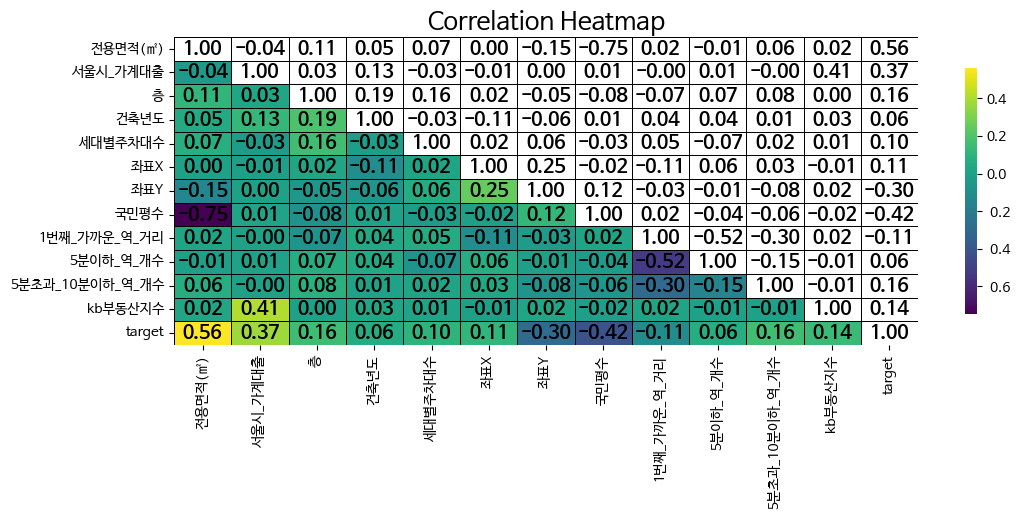

In [171]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

In [172]:
def model_randomforest():
    # 데이터 준비
    X = train.drop(columns=['target'])
    y = train['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # 범주형 열에 대한 레이블 인코딩
    def label_encode_columns(X, cols):
        for col in cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        return X

    # 전처리 및 모델 파이프라인 설정
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUMERIC_COLS),
            ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
        ], remainder='passthrough')

    # 모델 정의, 학습, 예측, 평가
    results = {}
    kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

    model = RandomForestRegressor(random_state=SEED)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(cv_scores))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results['RandomForest'] = {'R2 Score': r2, 'RMSE': rmse}

    # 결과 출력
    for model_name, metrics in results.items():
        print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  /  RMSE: {metrics['RMSE']:.4f}")


    import joblib
    # 모델 저장
    model_filename = f'random_forest_pipeline_rmse_{rmse:.4f}.pkl'
    joblib.dump(pipeline, model_filename)
    print(f"모델이 파일로 저장되었습니다: {model_filename}")

In [173]:
# 데이터 준비
X = train.drop(columns=['target'])
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 범주형 열에 대한 레이블 인코딩
def label_encode_columns(X, cols):
    for col in cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    return X

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', FunctionTransformer(label_encode_columns, kw_args={'cols': CAT_COLS}), CAT_COLS)
    ], remainder='passthrough')

def objective_cat(trial):
    model = CatBoostRegressor(
        # iterations=trial.suggest_int('iterations', 300, 800),
        # learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        # depth=trial.suggest_int('depth', 6, 20),
        random_state=SEED,
        verbose=0
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    return -np.mean(cv_scores)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params

# 각 모델의 하이퍼파라미터 최적화
n_trials = 3

cat_best_params = optimize_model(objective_cat, n_trials)
print("@@ CatBoost best params:", cat_best_params)

# 모델 정의, 학습, 예측, 평가
results = {}
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)

for model_name, model_class, best_params in [
    # ('XGBoost', XGBRegressor, xgb_best_params),
    ('CatBoost', CatBoostRegressor, cat_best_params)
]:
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(cv_scores))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'R2 Score': r2, 'RMSE': rmse}

# 결과 출력
for model_name, metrics in results.items():
    print(f"@@ model: {model_name}  /  R2: {metrics['R2 Score']:.4f}  /  RMSE: {metrics['RMSE']:.4f}")


[I 2024-07-18 14:12:38,268] A new study created in memory with name: no-name-4382d179-9a44-4753-b273-0017b1f7862c
[I 2024-07-18 14:12:58,666] Trial 0 finished with value: 71420406.95292184 and parameters: {}. Best is trial 0 with value: 71420406.95292184.
[I 2024-07-18 14:13:19,181] Trial 1 finished with value: 71420406.95292184 and parameters: {}. Best is trial 0 with value: 71420406.95292184.
[I 2024-07-18 14:13:39,689] Trial 2 finished with value: 71420406.95292184 and parameters: {}. Best is trial 0 with value: 71420406.95292184.


@@ CatBoost best params: {}
Learning rate set to 0.106376
0:	learn: 46902.6121906	total: 13.9ms	remaining: 13.9s
1:	learn: 43958.6281229	total: 25.9ms	remaining: 12.9s
2:	learn: 41387.8491914	total: 37.6ms	remaining: 12.5s
3:	learn: 39006.5972914	total: 49.7ms	remaining: 12.4s
4:	learn: 37022.6928150	total: 62.6ms	remaining: 12.5s
5:	learn: 35249.3629504	total: 74.6ms	remaining: 12.4s
6:	learn: 33668.9488015	total: 87.4ms	remaining: 12.4s
7:	learn: 32223.9678526	total: 99.7ms	remaining: 12.4s
8:	learn: 30978.0347246	total: 112ms	remaining: 12.3s
9:	learn: 29782.3479715	total: 123ms	remaining: 12.2s
10:	learn: 28700.8351924	total: 136ms	remaining: 12.2s
11:	learn: 27696.7749526	total: 149ms	remaining: 12.2s
12:	learn: 26871.1312354	total: 162ms	remaining: 12.3s
13:	learn: 26035.4218903	total: 173ms	remaining: 12.2s
14:	learn: 25325.0172676	total: 185ms	remaining: 12.2s
15:	learn: 24651.8371965	total: 197ms	remaining: 12.1s
16:	learn: 24055.9748271	total: 209ms	remaining: 12.1s
17:	learn

In [174]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수', 'kb부동산지수']
test = test[selected_feature_list]

impute_missing_values(test)

print((test.isnull().mean() * 100).to_string())

아파트명               0.0
전용면적(㎡)            0.0
서울시_가계대출           0.0
층                  0.0
건축년도               0.0
구                  0.0
동                  0.0
도로명                0.0
세대별주차대수            0.0
좌표X                0.0
좌표Y                0.0
top_apt            0.0
국민평수               0.0
1번째_가까운_역_이름       0.0
1번째_가까운_역_호선       0.0
1번째_가까운_역_거리       0.0
5분이하_역_개수          0.0
5분초과_10분이하_역_개수    0.0
kb부동산지수            0.0


In [175]:
print((test.isnull().mean() * 100).to_string())

아파트명               0.0
전용면적(㎡)            0.0
서울시_가계대출           0.0
층                  0.0
건축년도               0.0
구                  0.0
동                  0.0
도로명                0.0
세대별주차대수            0.0
좌표X                0.0
좌표Y                0.0
top_apt            0.0
국민평수               0.0
1번째_가까운_역_이름       0.0
1번째_가까운_역_호선       0.0
1번째_가까운_역_거리       0.0
5분이하_역_개수          0.0
5분초과_10분이하_역_개수    0.0
kb부동산지수            0.0


In [176]:
# 최종 모델 정의 및 학습
def train_and_predict(model_class, best_params):
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X, y)
    predictions = pipeline.predict(test)
    return predictions.astype(int)  # 예측값을 int로 변환

# 예측 및 저장
# print("Predicting using XGBoost...")
# xgb_predictions = train_and_predict(XGBRegressor, xgb_best_params)
# submission_xgb = pd.DataFrame({
#     'target': xgb_predictions
# })
# submission_xgb.to_csv(f'test_xgb_11059.5517.csv', index=False)

# print("Predicting using CatBoost...")
cat_predictions = train_and_predict(CatBoostRegressor, cat_best_params)
submission_cat = pd.DataFrame({
    'target': cat_predictions
})
submission_cat.to_csv(f'test_cat_8824.0791.csv', index=False)

Learning rate set to 0.117484
0:	learn: 46492.7995237	total: 24.3ms	remaining: 24.3s
1:	learn: 43272.7995802	total: 44.8ms	remaining: 22.4s
2:	learn: 40533.0667695	total: 66.3ms	remaining: 22s
3:	learn: 38009.7251267	total: 87.3ms	remaining: 21.7s
4:	learn: 35886.6941759	total: 107ms	remaining: 21.3s
5:	learn: 34001.6928193	total: 128ms	remaining: 21.2s
6:	learn: 32351.2144406	total: 150ms	remaining: 21.2s
7:	learn: 30890.1644435	total: 172ms	remaining: 21.4s
8:	learn: 29625.7658816	total: 194ms	remaining: 21.4s
9:	learn: 28499.5014860	total: 216ms	remaining: 21.4s
10:	learn: 27457.4752807	total: 237ms	remaining: 21.3s
11:	learn: 26406.7097747	total: 258ms	remaining: 21.2s
12:	learn: 25550.5206729	total: 278ms	remaining: 21.1s
13:	learn: 24790.4607684	total: 299ms	remaining: 21.1s
14:	learn: 24125.6681931	total: 320ms	remaining: 21s
15:	learn: 23492.3830079	total: 340ms	remaining: 20.9s
16:	learn: 22912.8630795	total: 360ms	remaining: 20.8s
17:	learn: 22443.1255048	total: 382ms	remaini